In [1]:
pip install tensorflow numpy pandas matplotlib seaborn scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the correct path
data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'  # Updated path
categories = ['brain_glioma', 'brain_menin', 'brain_tumor']
img_size = 128  # Resize to 128x128 for computational efficiency

# Debug: Verify the directory contents
print("Contents of data_dir:")
print(os.listdir(data_dir))

# Load images and labels
data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # 0, 1, or 2
    try:
        files = os.listdir(path)
        print(f"Found {len(files)} files in {path}")
        for img in files:
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_array is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                resized_array = cv2.resize(img_array, (img_size, img_size))
                data.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    except Exception as e:
        print(f"Error accessing directory {path}: {e}")

# Check if data was loaded
if len(data) == 0:
    raise ValueError("No images were loaded. Check the directory paths and image files.")

# Convert to numpy arrays
data = np.array(data).reshape(-1, img_size, img_size, 1)  # Add channel dimension
labels = np.array(labels)

# Normalize pixel values to [0, 1]
data = data / 255.0

# One-hot encode labels
labels = to_categorical(labels, num_classes=3)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

2025-04-23 11:00:31.345578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745406031.608362      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745406031.680532      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Contents of data_dir:
['brain_tumor', 'brain_glioma', 'brain_menin']
Found 2004 files in /kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma
Found 2004 files in /kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin
Found 2048 files in /kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor
Training set: (4239, 128, 128, 1), Validation set: (908, 128, 128, 1), Test set: (909, 128, 128, 1)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=4,
                    batch_size=32,
                    validation_data=(X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-23 11:01:42.920266: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/4
133/133 ━━━━━━━━━━━━━━━━━━━━ 63s 454ms/step - accuracy: 0.6021 - loss: 0.8425 - val_accuracy: 0.7324 - val_loss: 0.6235
Epoch 2/4
133/133 ━━━━━━━━━━━━━━━━━━━━ 60s 454ms/step - accuracy: 0.7550 - loss: 0.6065 - val_accuracy: 0.7225 - val_loss: 0.6374
Epoch 3/4
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.7787 - loss: 0.5333 - val_accuracy: 0.7863 - val_loss: 0.5099
Epoch 4/4
133/133 ━━━━━━━━━━━━━━━━━━━━ 58s 436ms/step - accuracy: 0.8226 - loss: 0.4426 - val_accuracy: 0.7533 - val_loss: 0.5871


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8012 - loss: 0.5533
Test Accuracy: 0.8097, Test Loss: 0.5234


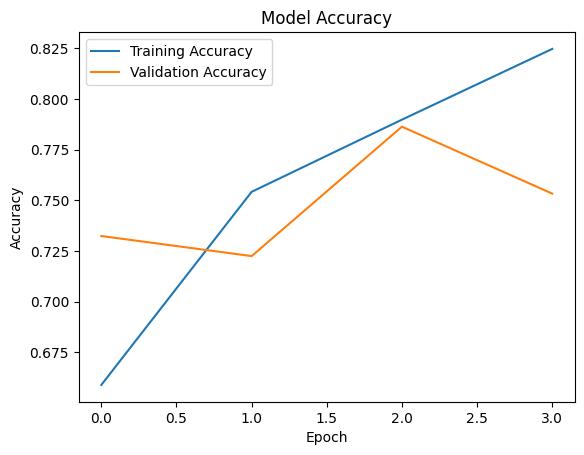

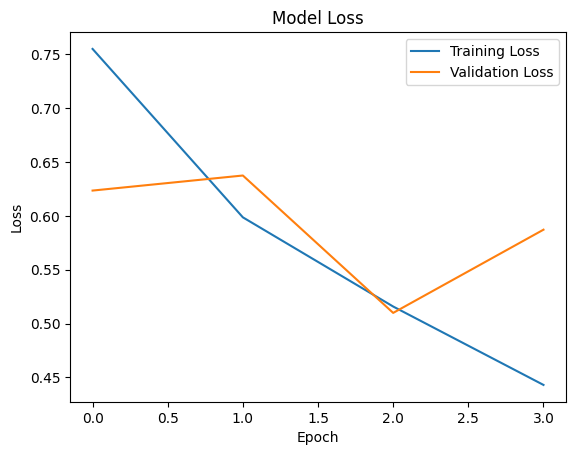

In [4]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


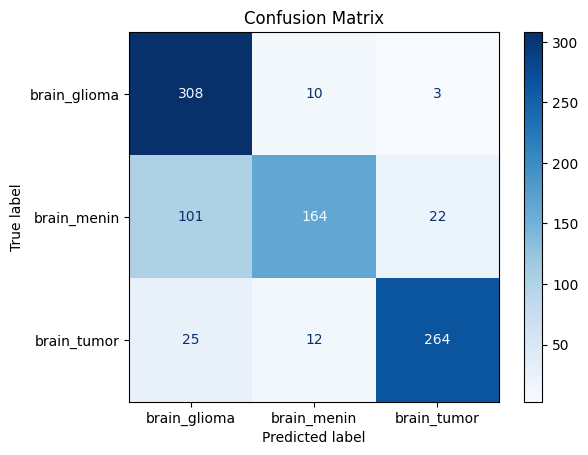

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=10,
          validation_data=(X_val, y_val))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 60s 443ms/step - accuracy: 0.6753 - loss: 0.7488 - val_accuracy: 0.7500 - val_loss: 0.5955
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 440ms/step - accuracy: 0.7192 - loss: 0.6594 - val_accuracy: 0.7335 - val_loss: 0.5742
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 442ms/step - accuracy: 0.7264 - loss: 0.6590 - val_accuracy: 0.8062 - val_loss: 0.4583
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 60s 445ms/step - accuracy: 0.7426 - loss: 0.6141 - val_accuracy: 0.8315 - val_loss: 0.4187
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 457ms/step - accuracy: 0.7455 - loss: 0.5944 - val_accuracy: 0.8502 - val_loss: 0.3942
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 439ms/step - accuracy: 0.7715 - loss: 0.5720 - val_accuracy: 0.8370 - val_loss: 0.4016
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 443ms/step - accuracy: 0.7652 - loss: 0.5788 - val_accuracy: 0.8359 - val_loss: 0.3873
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 453ms/step - accuracy: 0.7841 - loss: 0.5256 - val

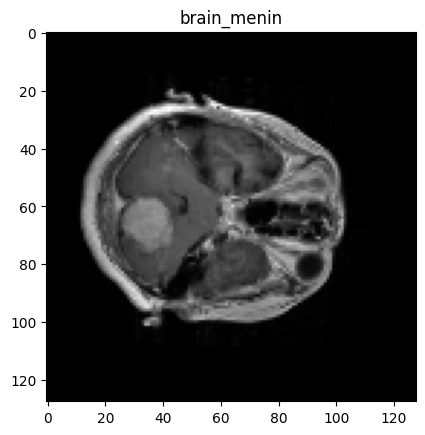

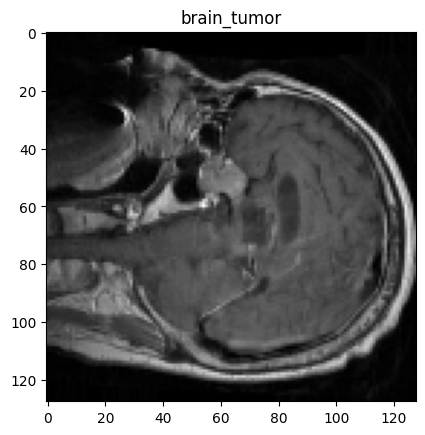

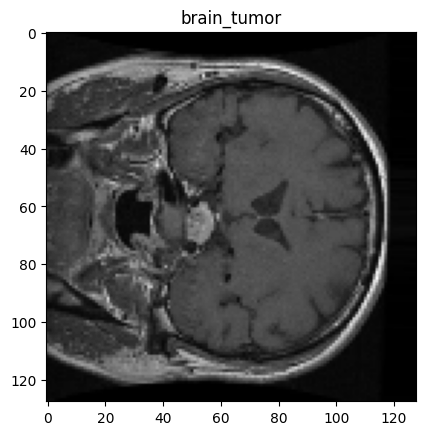

In [7]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.imshow(X_train[i].reshape(img_size, img_size), cmap='gray')
    plt.title(categories[np.argmax(y_train[i])])
    plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.8619 - loss: 0.3632
Test Accuracy: 0.8559, Test Loss: 0.3614


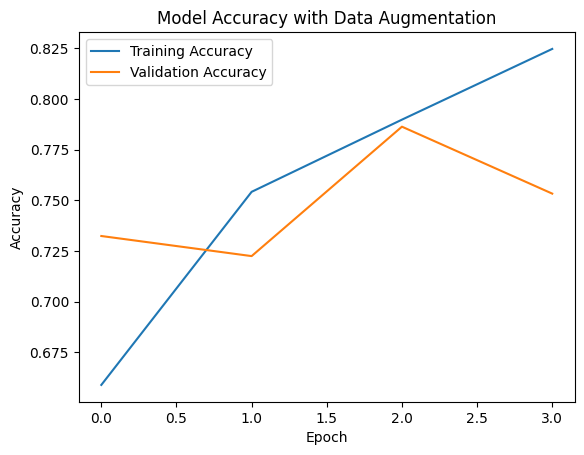

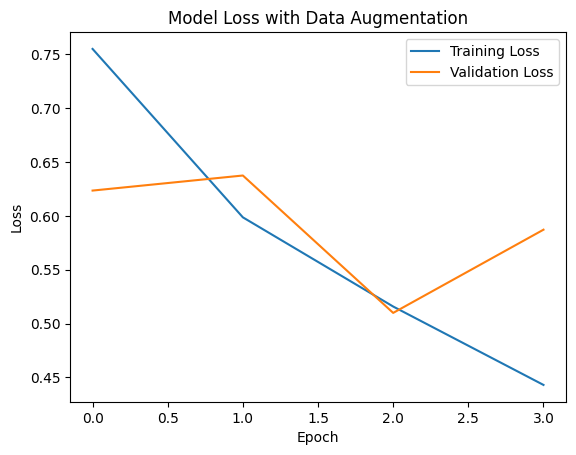

In [8]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

              precision    recall  f1-score   support

brain_glioma       0.71      0.96      0.82       321
 brain_menin       0.88      0.57      0.69       287
 brain_tumor       0.91      0.88      0.89       301

    accuracy                           0.81       909
   macro avg       0.83      0.80      0.80       909
weighted avg       0.83      0.81      0.80       909

